# OpenStreetMap Data Wrangling Project

### Map Area and data extration
The area selected (were I live) was [Costa Rican greater metropolitan area](https://www.openstreetmap.org/export#map=11/9.9428/-83.9960). The xml extract was obtained using [Overpass Query form](http://overpass-api.de/query_form.html) query: *(node(9.8156,-84.2868,10.0453,-83.8449); <; ); out meta;*.  The resulting osm file was named [costa_rica_greater_metropolitan_area.osm](costa_rica_greater_metropolitan_area.osm) (71.2 MB).

## Initial exploration
Using Notepad++ I managed to take a look at the XML file. Found some data quality issues that can be corrected just by looking at the raw data. ** I think [these findings](findings.txt) are a good starting point for a first few data cleaning iterations **
* Multiple node names have , and ; as part of their name.
* There are different ways to describe node attributes like postal code.
* There is html code in attribute values.
* There are multiple phone formats.

Proposed **[schema](https://gist.github.com/swwelch/f1144229848b407e0a5d13fcb7fbbd6f)**'s been used. Only **version** datatype was changed in data extraction from 'string' to 'integer' in order to match db schema. 

## Extraction, Transformation Load to SQLite database
Script **[extract_osm_data.py](extract_osm_data.py)** was used to parse osm xml, cleaning the data and generating required csv files used later to populate the osm database by calling method **process_map()**. Method **shape_element** transforms and apply the quality process in order to have quality data. It generates several CSV files that have the following attributes:   
* nodes.csv: 24.6 MB
* nodes_tags.csv: 0.7 MB
* ways.csv: 3.3 MB
* ways_tags.csv: 3.7 MB
* ways_nodes.cv: 9.4 MB 

As suggested in the module CSV files were imported to each table. Sqlite routines were *automated* in **[extract_osm_data.py](extract_osm_data.py)** by calling method **process_db**. This process results in osm_costa_rica.db (**37.1 MB**) with record count:
* select count(*) from nodes; 299725
* select count(*) from nodes_tags; 20095
* select count(*) from ways; 54689
* select count(*) from ways_tags; 107826
* select count(*) from ways_nodes; 386122

# Audit data
* **Validity (conforms to schema):** Validations already applied using [extract_osm_data.py](extract_osm_data.py) script like:  data type validations against the schema provided, checking if there are problematic characters (commas for example) in the data that could cause some problem in CSV format and verifying we are sending the right types to the CSV. Phone number formats, we found several phone number formats that can be unified. Tag names with wrong data, that contains problematic characters or html code that can be cleaned (not ignored).
* **Accuracy (conforms to gold standard)**: In some cases, specially in node or way names are will not match "expected names" corrections will be required.
* **Completeness (are there missing values)**: A basic process was already applied in osm data extraction; besides that, I will be checking if there are missing values or ids with null values. 
* **Consistency (matches other data)**: I will verify referencial integrity by checking if foreign keys are well established. 
* **Uniformity (same units)**: There are a few cases where units will be validate to comply uniformity.

### Using is_Problematic funtion to improve cleaning process
As you can see in **[extract_osm_data.py](extract_osm_data.py)** script, every time a value is identified as problematic using method **is_problematic** the values is *showed* to standard output once script is running. This as help me identified and corrected invalid value formats. In each iteration a new value is added to **MAPPING_CHARS** dictionary in order to replace wrong data with valid ones.

### Nodes and Ways
* I initially looked for **completeness** in nodes but after some exploration the data looks complete with **[this script](completeness_check.sql)**.
* Then I looked for some basic analysis to visualize user collaboration by nodes and check **uniformity** (not weird outliers, etc). For example, the following query let me conclude that users looks normal with **[this script](uniformity_check.txt)**. From 299725 user contributors, there are at least 800 users that collaborates with less than 100 articles but the most active user accounts for 56225 nodes. A dozen people are the greatest contributors. Id, Lat and Lon does not contains NaN or 0 values.

### Nodes and Ways Tags
* Nodes tags **types are consistent**, there are no duplicate types that require unification, verified using the **[this query](consistency_check.txt)**.
* But node tags **names** maybe not so much, we could have duplicated keys as seen in **[this query](duplicates_check.txt)**.
* Now, if we look at some of the nodes_tags it seems there's no need worry since those keys are used when you have more than one type of attribute, like several **phone** numbers or **names**, for example:
```
select * from nodes_tags where id = 3445201840;
id|key|value|type
3445201840|phone|2253-8426|contact
3445201840|phone_1|2253-8367|contact
```
* Looking closer to postal codes, I found that postal code key is used both as postcode or postal_code and **needs uniformity**. Values looks good though:
```
select * from nodes_tags where key like '%post%';
267631593|postal_code|40901|regular
267631658|postcode|40501|addr
```
* To explore nodes_tags **values** I will focus in the top 40 of 211 (20%) keys and for those keys I'll take a look at the values to see if there are quality issues to fix. **[This query](invalid_names_check.txt)** describes this selection.
* Finally, I found some values that can be corrected to conform **accuracy** since I know there are wrong like stores names. NAMING dictionary in **[extract_osm_data.py](extract_osm_data.py)** describes those places with wrong names and correct ones.
* Also, by looking at phone key, I found that there are multiple phone number formats and they need to be corrected to conform **consistency** with (506)########. Phone with less than 8 numeric characters will be excluded as **[seen here](phone_check.txt)**.
* Also, **uniformity** in numeric keys like 'population' **[looks alright](phone_check.txt)**.

# Cleaning plan

These are the elements I will focus for data cleaning and applied using **extract_osm_data.py** script. **Validity** check was applied to comply **schema** validation. Postal_code and postcode need to comply **uniformity** in a single field. Phone numbers require **consistency** between formats. Tag name values need to be corrected to apply conform **accuracy** to match a expected value list. There are missing referenced nodes in ways_nodes entity to conform **completeness**. We need to verify why.

All those points are addressed programattically using **[extract_osm_data.py](extract_osm_data.py)** script using function **shape_element()**.

### Postal code unification
**Causes**: No reasonable cause was found since similar records with the same user reports two different ways to describe a postcode. *postcode* key with type 'addr' will be selected as the correct to specify updating wrong records in our database: 
```
<tag k="postal_code" v="40901"/>
<tag k="addr:postcode" v="40501"/>
```
**Operations**: **[extract_osm_data.py](extract_osm_data.py)** script contains the function **fix_postcodes** that updates nodes and ways tags table to unify postalcode keys and values similar to:
```
UPDATE nodes_tags SET key = 'postcode', type = 'addr' WHERE key='postal_code';
UPDATE ways_tags SET key = 'postcode', type = 'addr' WHERE key='postal_code';
```

**Test**: Once applied the change, the following script does not return any data, as expected.
```
select * from nodes_tags where key = 'postal_code';
select * from ways_tags where key = 'postal_code';
```
** Result**: successful.

### Phone number standarization
**Causes**: users included different phone number gathered from different places and it has caused this issue. 

**Operations**: **[extract_osm_data.py](extract_osm_data.py)** use routines that validate for problematic phone numbers and fix them. Following these steps:

* Validates if each value matches the expected phone number using Apply function **is_valid_phone**.
* If there is a mismatch, the script apply a new format with function **fix_phone**.

**Test**: Once applied the change, the following script returns only well formated phone numbers, as expected.
```
select value from nodes_tags where key = 'phone';
select value from ways_tags where key = 'phone';
```
** Result**: successful, only 15 numbers were ignored to apply manual correction.

### Tag names correction
**Causes**: acccents, dash and other character are causing inconsistencies among names.

**Operations**: **[extract_osm_data.py](extract_osm_data.py)** script contains the method **fix_name** to conform consistency using MAPPING dictionary to validate wrong names and set expected ones
* if the tag name in a to_be_corrected name list, then it will return the expected name to be updated.
* Accents and encoding is managed to apply correct spanish names.
* Mapping is used to compare and set expected data:
**Test**: the same query will be applied to verify names are now alright for either nodes_tags or ways_tags:

```
select distinct a.key, b.value from (select  key,count(*) as total_key from nodes_tags group by key order by count(*) desc limit 40) a join nodes_tags b on a.key = b.key order by a.total_key desc;

```
** Result**: successful, it replaces wrong names with correct ones.

### Missing reference way_nodes assesment
**Causes** After a few minutes I concluded that it was a mistake. I had to apply **left outer joins** to correctly compare tables:
```
select count(*) from ways_nodes a; -> 386122
select count(*) from ways_nodes a left outer join nodes b on a.node_id = b.id; ->386122
sqlite> select count(*) from ways_nodes a left outer join ways b on a.id = b.id; -> 386122
```
**Result**: Nothing to do, all good!

# Applying cleaning plan
**[extract_osm_data.py](extract_osm_data.py)** script can be executed several times to programmatically clean our data following the cleaning plan described above. Every time it looks for OSM file and finally creates and loads cleaned data.

# Ideas around OSM information

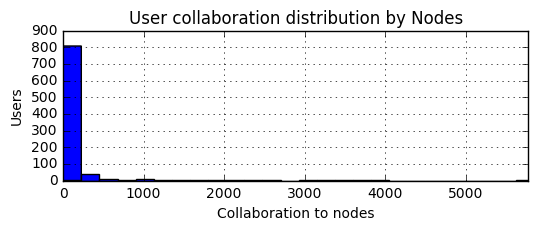

In [1]:
%matplotlib inline
import graph

* **Contributors**: Once reviewed the information extracted from OSM, Costa Rica has a small group of contributors (299725). There are at least 800 users that collaborates with less than 100 articles but the most active user accounts for 56225 nodes. A dozen people are the greatest contributors. Most data comes from  "KG Ground Survey 2014". 
* **Contributions by year**: Since 2007, 2016 was by far the year with more contributions to nodes and ways with 13094 new records added to OSM Costa Rican GAM. Sadly 2017 as been a poor year with 3177, contribution wise. **Something happened with OMS contributions in 2017**. You can see additional details **[here](detailed_contrib.txt)**.
* **Top sources**: [Filtering and grouping data query](contributors.txt) by source we can verify OSM imported information comes almost entirely from KG Ground Surveys. In 2015 it accounted for more than 10,000 tags recorded. Also we can notice KG ground survey stopped in 2016, that's why we are seen less data collected in 2017.
* **Locations close to a point**:  Using basic Pythagoras theorem I've calculated some basic points close to me (Santo Domingo, Heredia, Costa Rica [9.979931, -84.091026]). There are other sophisticated but accurate ways to calclulate distances in Km but it was difficult in SQLite since we don't have the ACOS function.
```
sqlite> SELECT b.id,lat,lon,key,value FROM nodes a join nodes_tags b ON a.id = b.id ORDER BY (ABS(a.lat - 9.979931) + ABS(a.lon - -84.091026))  ASC limit 50;
```

**Idea:** If we group by Id we can get key close locations given a point. This is really usefull when creating tematic apps that show relevant places. Lets say we have an app that shows nerby shop places with offers. Its that simple to filter by key **show** and then matching that node id with out *offers* table. 

# Gathering data to improve OSM

**Idea**: Looking at Costa Rican apps, there are several options that already benefit from geolocation and that can ask for users feedback to improve data like http://yoviajocr.com/chronos/ that shows bus stops in Costa Rica. Since bus stops are always changing, integrating the app to Open Street Map can create a win-win effect. 

This is really important since as of now the data collected for Costa Rica is very dependant on **KG Ground Survey**.

# Benefits and problems in implementing the improvement 

**Benefits**: All these fixes improve data interpretation and facilitates automation by using accurate and valid data.
* The set now contains unified phones format that an app or any other automated service can use more accurately.
* Postcodes tag is always a problem in Costa Rica, unifying those attributes would make location easier.
* Tag names had lots of abbreviations that can be confusing, specially for those who don't live in Costa Rica: for example: No. is number, Dr is Doctor, Urb is a Town. It was fixed.
* Accents is another common error which required correction, in tag names.

**Anticipated problems**:
* There were several tags for a singles node or ways that had duplicated nested child tags information like names, phones, postcodes. These tags usually use posfix _1, _2 that make simplyfication complicated.
* In phone numbers specially there are sevaral string separators like |, /, and even commas that require further cleaning.
* In some cases are redundant tags that shows similar information, that even when sintaxis is correct, semantics are not: like shop, description, names, operator ... those can be simplified ... but with much more effort.
* Fixing not correctly connected ways nodes would be really interesting to assure routes calculation or well defined areas but it also requires much more effort.
* Dealing with encoding and accents was problematic since it's Spanish language.

# References
I tried to follow as much Audacity resources as possible but got impacted by encoding issues. Some findings are included as comments in the code, Besides course material and [forum feedback](https://discussions.udacity.com/t/are-the-csvs-supposed-to-be-double-spaced/285305/5), I used **Stackoverflow** to deal with some issues. [See list here](references.txt)